## ANOVA One-Way Tests and Permutation Tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Data Preparation

In [2]:
# task dictionary
task_dict = {
    'stroop_vanilla': 'task-td7i',
    'stroop_progressbar': 'task-lupf',
    'stroop_eyes': 'task-c9op',
    'stroop_video': 'task-1l71',
    'stroop_posneg': 'task-on6n',
    'stroop_final': 'task-7g42',
    'stroop_bonus': 'task-3kpz',
    'rdk_vanilla': 'task-2ywa',
    'rdk_progressbar': 'task-sks3',
    'rdk_eyes': 'task-zyvq',
    'rdk_video': 'task-6e3k',
    'rdk_posneg': 'task-ivrk',
    'rdk_final': 'task-sq3v',
    'rdk_bonus': 'task-hvii',
    'bandit_vanilla': 'task-dwkr',
    'bandit_progressbar': 'task-25bt',
    'bandit_eyes': 'task-x158',
    'bandit_video': 'task-9ndm',
    'bandit_posneg': 'task-tzk1',
    'bandit_final': 'task-gn7s',
    'bandit_bonus': 'task-iaas',
}

# task-separated arrays
stroop_arr = ["stroop_vanilla", "stroop_progressbar", "stroop_eyes", "stroop_video", "stroop_posneg", "stroop_final", "stroop_bonus"]
rdk_arr = ["rdk_vanilla", "rdk_progressbar", "rdk_eyes", "rdk_video", "rdk_posneg", "rdk_final", "rdk_bonus"]
bandit_arr = ["bandit_vanilla", "bandit_progressbar", "bandit_eyes", "bandit_video", "bandit_posneg", "bandit_final", "bandit_bonus"]

In [3]:
stroop_df = pd.read_csv('data/stroop_df.csv')
rdk_df = pd.read_csv('data/rdk_df.csv')
bandit_df = pd.read_csv('data/bandit_df.csv')

C:\Users\Devank\AppData\Local\Temp\ipykernel_16656\2777224126.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  stroop_df = pd.read_csv('data/stroop_df.csv')
C:\Users\Devank\AppData\Local\Temp\ipykernel_16656\2777224126.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  rdk_df = pd.read_csv('data/rdk_df.csv')
C:\Users\Devank\AppData\Local\Temp\ipykernel_16656\2777224126.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  bandit_df = pd.read_csv('data/bandit_df.csv')


In [4]:
def accuracy_df_builder(df, arr, task):
    
    performance_df = pd.DataFrame(columns=['Participant', 'Task', 'Manipulation', 'Accuracy'])
    for manip in arr:

        focus_df = df[df['Tree Node Key'] == task_dict[manip]]
        participants = focus_df['Participant Private ID'].unique().tolist()
        if len(participants) < 1:
            accuracies.append(overall_accuracy)
            continue
        
        for participant in participants:
            participant_df = focus_df[focus_df['Participant Private ID'] == participant]
            participant_df = participant_df[participant_df['Screen Name'] == 'trial'][['Attempt', 'Correct', 'Incorrect', 'Local Date']]

            if participant_df.empty:
                participants.remove(participant)
                continue

            # for timeouts
            participant_df['Attempt'].fillna(0, inplace = True)
            
            accuracy = participant_df['Correct'].sum() * 100 / len(participant_df)
            date = participant_df['Local Date'].iloc[0]
            performance_df = performance_df.append({
                'Participant': participant,
                'Task': task,
                'Manipulation': manip,
                'Accuracy': accuracy,
                'Date': date
            }, ignore_index=True)
            
    return performance_df

In [5]:
def sample_equal_rows(df, column, count):
    
    new_df = pd.DataFrame(columns=df.columns)
    for value in df[column].unique():
        new_df = new_df.append(df[df[column] == value].sample(count))
    return new_df

In [6]:
stroop_acc_df = accuracy_df_builder(stroop_df, stroop_arr, "Stroop")
stroop_acc_df.reset_index(inplace=True)
rdk_acc_df = accuracy_df_builder(rdk_df, rdk_arr, "RDK")
rdk_acc_df.reset_index(inplace=True)
bandit_acc_df = accuracy_df_builder(bandit_df, bandit_arr, "Bandit")
bandit_acc_df.reset_index(inplace=True)

performance_df = pd.concat([stroop_acc_df, rdk_acc_df, bandit_acc_df])
performance_df.reset_index(inplace=True)
print(performance_df['Date'])

0       07/03/2023 10:24:04
1       07/03/2023 10:21:21
2       07/03/2023 10:32:20
3       07/03/2023 10:14:42
4       08/03/2023 10:01:55
               ...         
1635    26/03/2023 10:45:06
1636    27/03/2023 09:59:08
1637    27/03/2023 10:00:51
1638    27/03/2023 10:02:26
1639    27/03/2023 10:03:19
Name: Date, Length: 1640, dtype: object


In [7]:
stroop_acc_df['Date'] = pd.to_datetime(stroop_acc_df['Date'], format="%d/%m/%Y %H:%M:%S")
rdk_acc_df['Date'] = pd.to_datetime(rdk_acc_df['Date'], format="%d/%m/%Y %H:%M:%S")
bandit_acc_df['Date'] = pd.to_datetime(bandit_acc_df['Date'], format="%d/%m/%Y %H:%M:%S")
performance_df['Date'] = pd.to_datetime(performance_df['Date'], format="%d/%m/%Y %H:%M:%S")

#### I. Comparing different tasks across manipulations

$H_0$: The mean performance of participants is statisitically similar for all three tasks (Stroop, RDK, bandit).

$H_a$: The mean performance of participants is significantly dissimilar for different tasks.

C:\Users\Devank\miniconda3\envs\nds\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\nds\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Devank\miniconda3\envs\nds\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


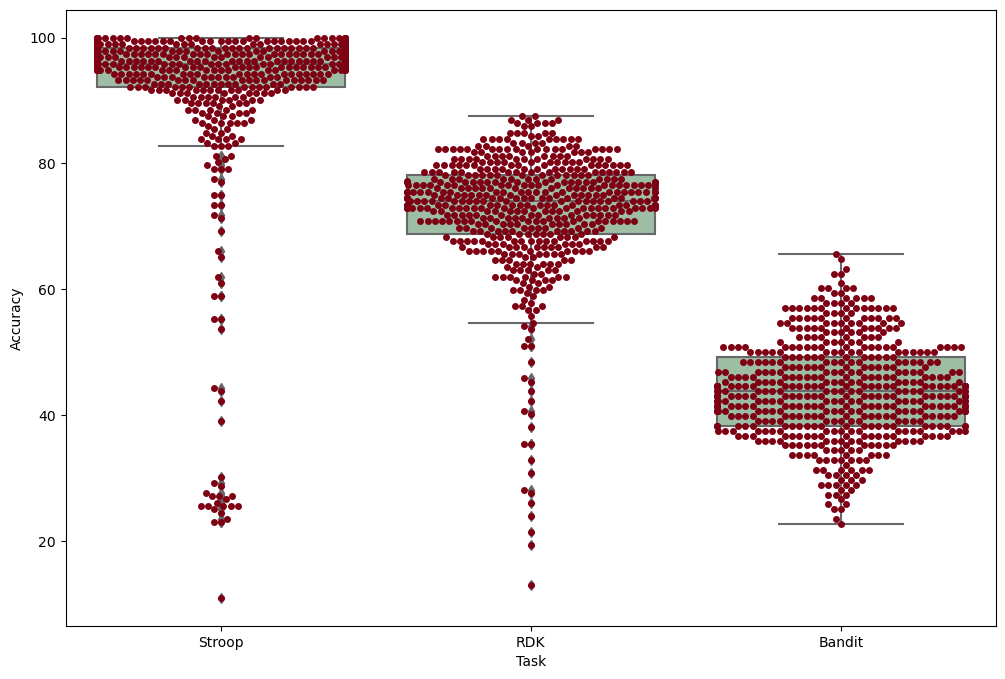

In [7]:
task_min_count = min(performance_df["Task"].value_counts())
task_performance_df = sample_equal_rows(performance_df, "Task", task_min_count)

fig = plt.figure(figsize=(12,8))
ax = sns.boxplot(x='Task', y='Accuracy', data=task_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Task", y="Accuracy", data=task_performance_df, color='#7d0013')

plt.show()

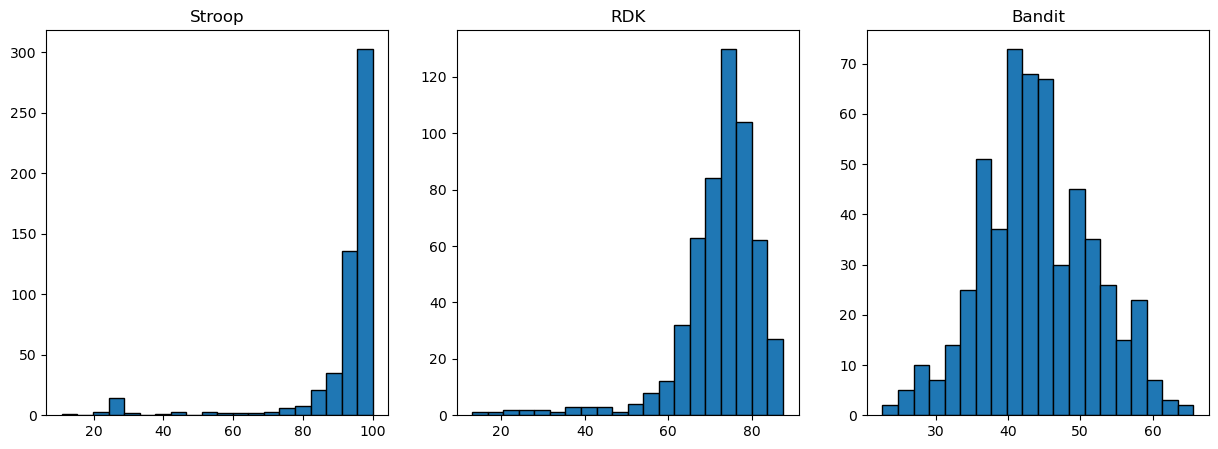

In [8]:
# fig = sm.qqplot(task_performance_df[task_performance_df["Task"] == "Stroop"]["Accuracy"], line='45')
fig = plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.hist(task_performance_df[task_performance_df["Task"] == "Stroop"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Stroop")
plt.subplot(1,3,2)
plt.hist(task_performance_df[task_performance_df["Task"] == "RDK"]["Accuracy"], edgecolor='black', bins=20)
plt.title("RDK")
plt.subplot(1,3,3)
plt.hist(task_performance_df[task_performance_df["Task"] == "Bandit"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Bandit")
plt.show()

In [9]:
model1 = ols('Accuracy ~ Task', data=task_performance_df).fit()
# test for normality - FAILED
print(stats.shapiro(model1.resid))


ShapiroResult(statistic=0.7125478982925415, pvalue=0.0)


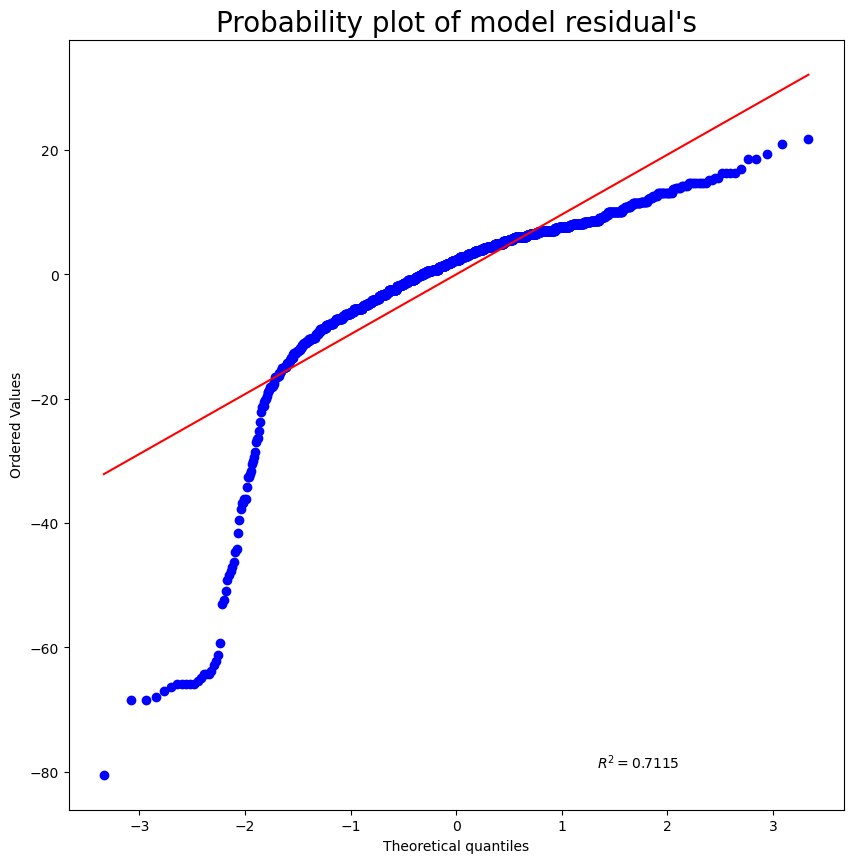

In [10]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model1.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

In [11]:
anova_table = sm.stats.anova_lm(model1, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Task,622084.540082,2.0,2392.917291,0.0
Residual,212134.780721,1632.0,NaN,NaN


###### How to interpret these results?

#### II. Comparing different manipulations across tasks

$H_0$: The mean performance of participants is statisitically similar for all seven manipulations.

$H_a$: The mean performance of participants is significantly dissimilar for different manipulations.

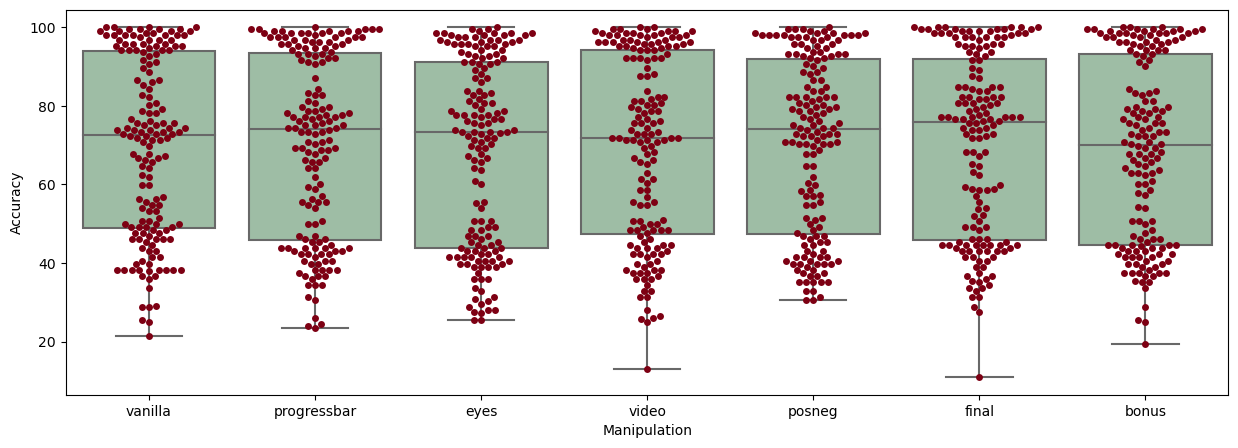

In [12]:
manip_performance_df = performance_df
manip_performance_df = manip_performance_df.replace('rdk_', '', regex=True)
manip_performance_df = manip_performance_df.replace('stroop_', '', regex=True)
manip_performance_df = manip_performance_df.replace('bandit_', '', regex=True)

manip_min_count = min(manip_performance_df["Manipulation"].value_counts())
manip_performance_df = sample_equal_rows(manip_performance_df, "Manipulation", manip_min_count)

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=manip_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=manip_performance_df, color='#7d0013')
plt.show()

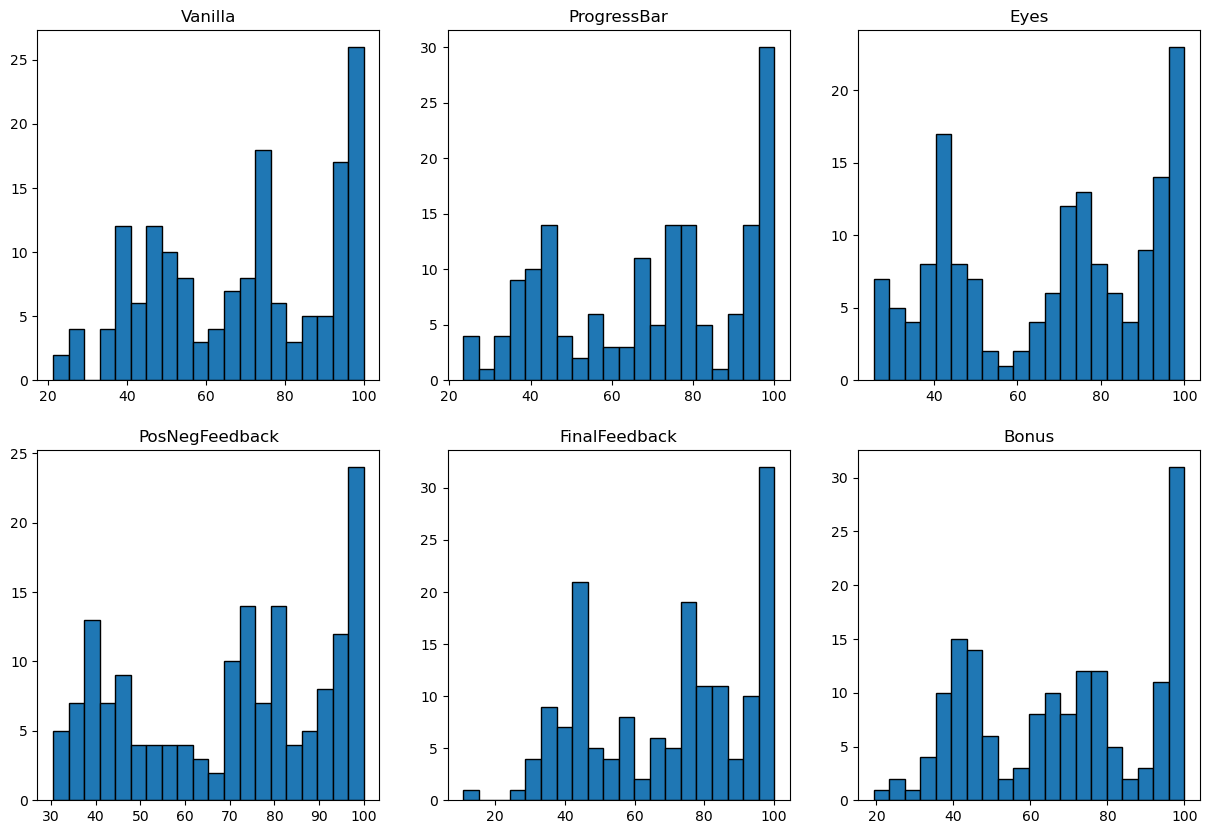

In [13]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "vanilla"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Vanilla")
plt.subplot(2,3,2)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "progressbar"]["Accuracy"], edgecolor='black', bins=20)
plt.title("ProgressBar")
plt.subplot(2,3,3)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "eyes"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Eyes")
plt.subplot(2,3,4)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "posneg"]["Accuracy"], edgecolor='black', bins=20)
plt.title("PosNegFeedback")
plt.subplot(2,3,5)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "final"]["Accuracy"], edgecolor='black', bins=20)
plt.title("FinalFeedback")
plt.subplot(2,3,6)
plt.hist(manip_performance_df[manip_performance_df["Manipulation"] == "bonus"]["Accuracy"], edgecolor='black', bins=20)
plt.title("Bonus")
plt.show()

In [14]:
model2 = ols('Accuracy ~ Manipulation', data=manip_performance_df).fit()
print(stats.shapiro(model2.resid))

ShapiroResult(statistic=0.9229611754417419, pvalue=1.7394870476162737e-23)


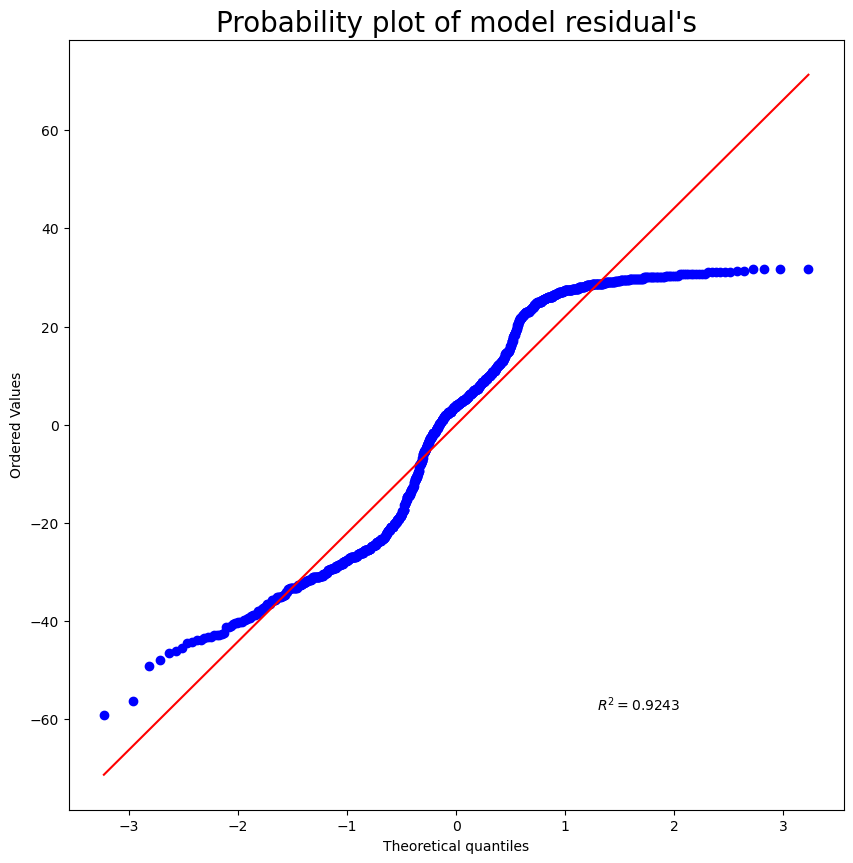

In [15]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model2.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

In [16]:
anova_table = sm.stats.anova_lm(model2, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,626.095927,6.0,0.197884,0.977434
Residual,586912.600637,1113.0,NaN,NaN


### WITHIN TASK ANOVAs

#### I. Stroop

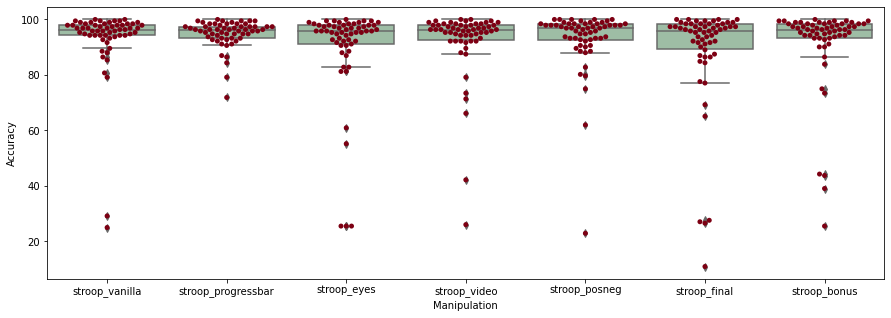

In [17]:
stroop_performance_df = performance_df[performance_df["Task"] == "Stroop"]
stroop_performance_df = sample_equal_rows(stroop_performance_df, "Manipulation", min(stroop_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=stroop_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=stroop_performance_df, color='#7d0013')
plt.show()

In [18]:
model3 = ols('Accuracy ~ Manipulation', data=stroop_performance_df).fit()
print(stats.shapiro(model3.resid))

ShapiroResult(statistic=0.545053243637085, pvalue=4.491449656441061e-31)


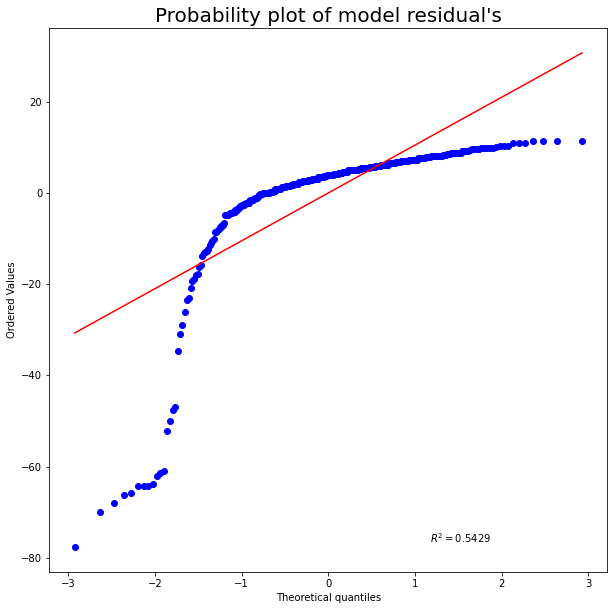

In [19]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model3.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

In [20]:
anova_table = sm.stats.anova_lm(model3, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,1558.120970,6.0,1.275873,0.267236
Residual,81211.091842,399.0,NaN,NaN


#### II. RDK

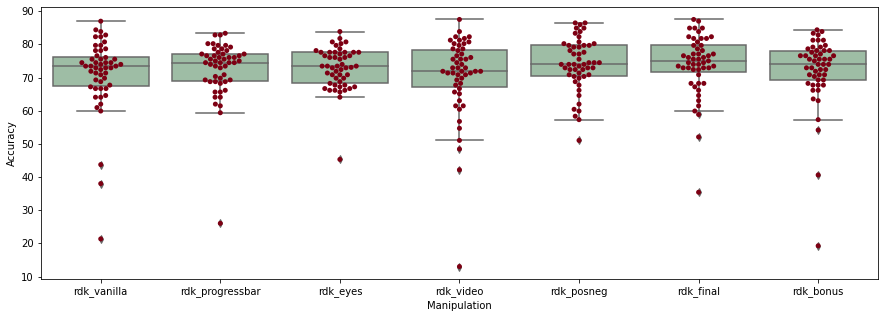

In [21]:
rdk_performance_df = performance_df[performance_df["Task"] == "RDK"]
rdk_performance_df = sample_equal_rows(rdk_performance_df, "Manipulation", min(rdk_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=rdk_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=rdk_performance_df, color='#7d0013')
plt.show()

In [22]:
model4 = ols('Accuracy ~ Manipulation', data=rdk_performance_df).fit()
print(stats.shapiro(model4.resid))

ShapiroResult(statistic=0.8211556673049927, pvalue=1.3278042779429569e-19)


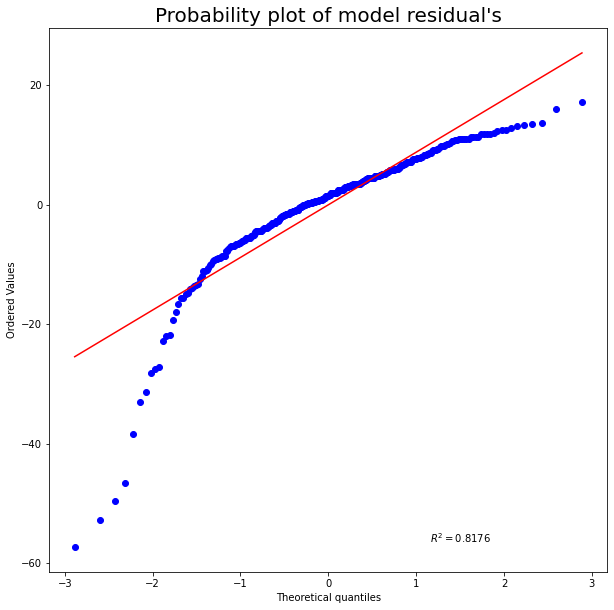

In [23]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model4.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

In [24]:
anova_table = sm.stats.anova_lm(model4, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,555.252906,6.0,0.968626,0.446326
Residual,33438.860127,350.0,NaN,NaN


#### III. Bandit

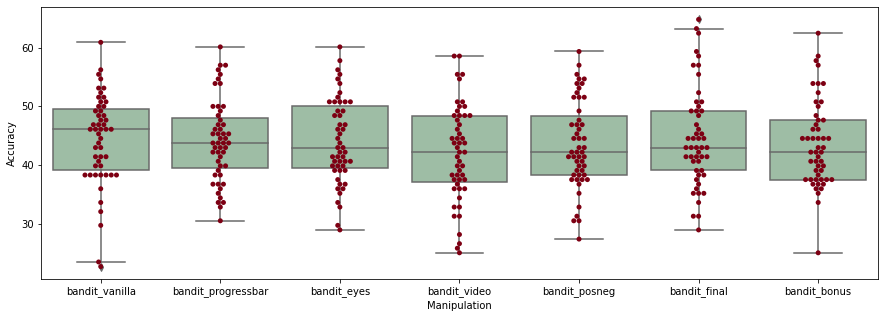

In [25]:
bandit_performance_df = performance_df[performance_df["Task"] == "Bandit"]
bandit_performance_df = sample_equal_rows(bandit_performance_df, "Manipulation", min(bandit_performance_df["Manipulation"].value_counts()))

fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(x='Manipulation', y='Accuracy', data=bandit_performance_df, color='#99c2a2')
ax = sns.swarmplot(x="Manipulation", y="Accuracy", data=bandit_performance_df, color='#7d0013')
plt.show()

In [26]:
model5 = ols('Accuracy ~ Manipulation', data=bandit_performance_df).fit()
print(stats.shapiro(model5.resid))

ShapiroResult(statistic=0.9944463968276978, pvalue=0.2223559319972992)


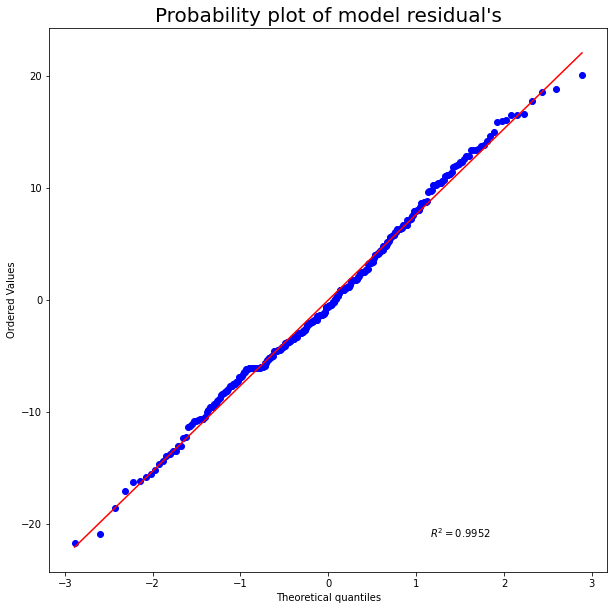

In [27]:
# another test for normality

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model5.resid, plot=plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

In [28]:
anova_table = sm.stats.anova_lm(model5, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Manipulation,227.167039,6.0,0.640219,0.698027
Residual,20698.242188,350.0,NaN,NaN


## Permutation Tests

Let's see how this goes.

In [17]:
def statistic(x, y):
    return (np.mean(x) - np.mean(y))

In [18]:
# comparing between two tasks

x = np.asarray(performance_df[performance_df["Task"] == "Stroop"][["Accuracy"]])
y = np.asarray(performance_df[performance_df["Task"] == "RDK"][["Accuracy"]])
z = np.asarray(performance_df[performance_df["Task"] == "Bandit"][["Accuracy"]])

print(statistic(x, y))
print(statistic(y, z))
print(statistic(z, x))


19.159604116748085
28.36994824118542
-47.529552357933504


In [19]:
res = stats.permutation_test((x, y), statistic, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[19.15960412]
[0.00019998]


In [20]:
res = stats.permutation_test((y, z), statistic, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[28.36994824]
[0.00019998]


In [21]:
res = stats.permutation_test((x, z), statistic, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[47.52955236]
[0.00019998]


All these permutation tests reject the null hypotheses. Therefore, we can say that the main effect of tasks is pairwise significant.

#### Permutation tests for manipulations

In [47]:
manip_1 = performance_df[performance_df["Manipulation"].str.contains("vanilla")]
manip_2 = performance_df[performance_df["Manipulation"].str.contains("progress")]
manip_3 = performance_df[performance_df["Manipulation"].str.contains("eyes")]
manip_4 = performance_df[performance_df["Manipulation"].str.contains("posneg")]
manip_5 = performance_df[performance_df["Manipulation"].str.contains("final")]
manip_6 = performance_df[performance_df["Manipulation"].str.contains("bonus")]
manip_7 = performance_df[performance_df["Manipulation"].str.contains("video")]

##### Stroop

In [48]:
str_manip_1 = manip_1[manip_1["Task"] == "Stroop"][["Accuracy"]]
str_manip_2 = manip_2[manip_2["Task"] == "Stroop"][["Accuracy"]]
str_manip_3 = manip_3[manip_3["Task"] == "Stroop"][["Accuracy"]]
str_manip_4 = manip_4[manip_4["Task"] == "Stroop"][["Accuracy"]]
str_manip_5 = manip_5[manip_5["Task"] == "Stroop"][["Accuracy"]]
str_manip_6 = manip_6[manip_6["Task"] == "Stroop"][["Accuracy"]]
str_manip_7 = manip_7[manip_7["Task"] == "Stroop"][["Accuracy"]]

print(len(str_manip_7))

58


In [24]:
# vanilla vs progress-bar
res = stats.permutation_test((str_manip_1, str_manip_2), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.51779049]
[0.82491751]


In [25]:
# vanilla vs eyes
res = stats.permutation_test((str_manip_1, str_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[4.03095091]
[0.12438756]


In [26]:
# vanilla vs posneg
res = stats.permutation_test((str_manip_1, str_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.89963601]
[0.64073593]


In [27]:
# vanilla vs final
res = stats.permutation_test((str_manip_1, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[3.29553975]
[0.20557944]


In [28]:
# vanilla vs bonus
res = stats.permutation_test((str_manip_1, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.95138372]
[0.70052995]


In [49]:
# vanilla vs video
res = stats.permutation_test((str_manip_1, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.24757202]
[0.91690831]


In [29]:
# progress-bar vs eyes
res = stats.permutation_test((str_manip_2, str_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[4.5487414]
[0.07059294]


In [30]:
# progress-bar vs posneg
res = stats.permutation_test((str_manip_2, str_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.38184552]
[0.85411459]


In [31]:
# progress-bar vs final
res = stats.permutation_test((str_manip_2, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[3.81333024]
[0.13878612]


In [32]:
# progress-bar vs bonus
res = stats.permutation_test((str_manip_2, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.46917421]
[0.54454555]


In [50]:
# progress-bar vs video
res = stats.permutation_test((str_manip_2, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.76536251]
[0.73832617]


In [33]:
# eyes vs posneg
res = stats.permutation_test((str_manip_3, str_manip_4), statistic, vectorized=False, n_resamples=1e4)#, alternative='less')
print(res.statistic)
print(res.pvalue)

[-4.93058692]
[0.0419958]


In [34]:
# eyes vs final
res = stats.permutation_test((str_manip_3, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.73541116]
[0.79652035]


In [35]:
# eyes vs bonus
res = stats.permutation_test((str_manip_3, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-3.07956719]
[0.27117288]


In [51]:
# eyes vs video
res = stats.permutation_test((str_manip_3, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-3.78337889]
[0.179982]


In [36]:
# posneg vs final
res = stats.permutation_test((str_manip_4, str_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[4.19517576]
[0.07859214]


In [37]:
# posneg vs bonus
res = stats.permutation_test((str_manip_4, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.85101973]
[0.37236276]


In [52]:
# posneg vs video
res = stats.permutation_test((str_manip_4, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.14720803]
[0.57474253]


In [38]:
# final vs bonus
res = stats.permutation_test((str_manip_5, str_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-2.34415604]
[0.38876112]


In [53]:
# final vs video
res = stats.permutation_test((str_manip_5, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-3.04796773]
[0.29357064]


In [54]:
# bonus vs video
res = stats.permutation_test((str_manip_6, str_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.7038117]
[0.80591941]


##### RDK

In [55]:
rdk_manip_1 = manip_1[manip_1["Task"] == "RDK"][["Accuracy"]]
rdk_manip_2 = manip_2[manip_2["Task"] == "RDK"][["Accuracy"]]
rdk_manip_3 = manip_3[manip_3["Task"] == "RDK"][["Accuracy"]]
rdk_manip_4 = manip_4[manip_4["Task"] == "RDK"][["Accuracy"]]
rdk_manip_5 = manip_5[manip_5["Task"] == "RDK"][["Accuracy"]]
rdk_manip_6 = manip_6[manip_6["Task"] == "RDK"][["Accuracy"]]
rdk_manip_7 = manip_7[manip_7["Task"] == "RDK"][["Accuracy"]]

print(len(rdk_manip_7))

51


In [52]:
# vanilla vs progress-bar
res = stats.permutation_test((rdk_manip_1, rdk_manip_2), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.61223571]
[0.2929707]


In [53]:
# vanilla vs eyes
res = stats.permutation_test((rdk_manip_1, rdk_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.13713461]
[0.92430757]


In [54]:
# vanilla vs posneg
res = stats.permutation_test((rdk_manip_1, rdk_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-3.47808251]
[0.01079892]


In [55]:
# vanilla vs final
res = stats.permutation_test((rdk_manip_1, rdk_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-2.2054257]
[0.14818518]


In [56]:
# vanilla vs bonus
res = stats.permutation_test((rdk_manip_1, rdk_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.16780694]
[0.92370763]


In [56]:
# vanilla vs video
res = stats.permutation_test((rdk_manip_1, rdk_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.88507625]
[0.63413659]


In [57]:
# progress-bar vs eyes
res = stats.permutation_test((rdk_manip_2, rdk_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.47510111]
[0.36376362]


In [58]:
# progress-bar vs posneg
res = stats.permutation_test((rdk_manip_2, rdk_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.8658468]
[0.15378462]


In [59]:
# progress-bar vs final
res = stats.permutation_test((rdk_manip_2, rdk_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.59318999]
[0.67953205]


In [60]:
# progress-bar vs bonus
res = stats.permutation_test((rdk_manip_2, rdk_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.78004265]
[0.26957304]


In [58]:
# progress-bar vs video
res = stats.permutation_test((rdk_manip_2, rdk_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[2.49731196]
[0.19658034]


In [61]:
# eyes vs posneg
res = stats.permutation_test((rdk_manip_3, rdk_manip_4), statistic, vectorized=False, n_resamples=1e4)#, alternative='less')
print(res.statistic)
print(res.pvalue)

[-3.34094791]
[0.02419758]


In [62]:
# eyes vs final
res = stats.permutation_test((rdk_manip_3, rdk_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-2.06829109]
[0.2059794]


In [63]:
# eyes vs bonus
res = stats.permutation_test((rdk_manip_3, rdk_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.30494155]
[0.87271273]


In [57]:
# eyes vs video
res = stats.permutation_test((rdk_manip_3, rdk_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.02221086]
[0.61253875]


In [64]:
# posneg vs final
res = stats.permutation_test((rdk_manip_4, rdk_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.27265681]
[0.34076592]


In [65]:
# posneg vs bonus
res = stats.permutation_test((rdk_manip_4, rdk_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[3.64588945]
[0.01419858]


In [59]:
# posneg vs video
res = stats.permutation_test((rdk_manip_4, rdk_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[4.36315877]
[0.01339866]


In [66]:
# final vs bonus
res = stats.permutation_test((rdk_manip_5, rdk_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[2.37323264]
[0.14258574]


In [60]:
# final vs video
res = stats.permutation_test((rdk_manip_5, rdk_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[3.09050195]
[0.11018898]


In [61]:
# bonus vs video
res = stats.permutation_test((rdk_manip_6, rdk_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.71726931]
[0.72732727]


##### Bandit

In [80]:
bandit_manip_1 = manip_1[manip_1["Task"] == "Bandit"][["Accuracy"]]
bandit_manip_2 = manip_2[manip_2["Task"] == "Bandit"][["Accuracy"]]
bandit_manip_3 = manip_3[manip_3["Task"] == "Bandit"][["Accuracy"]]
bandit_manip_4 = manip_4[manip_4["Task"] == "Bandit"][["Accuracy"]]
bandit_manip_5 = manip_5[manip_5["Task"] == "Bandit"][["Accuracy"]]
bandit_manip_6 = manip_6[manip_6["Task"] == "Bandit"][["Accuracy"]]
bandit_manip_7 = manip_7[manip_7["Task"] == "Bandit"][["Accuracy"]]

print(bandit_manip_7.head())

      Accuracy
1339  49.21875
1340  39.84375
1341  35.93750
1342  43.75000
1343  25.00000


In [68]:
# vanilla vs progress-bar
res = stats.permutation_test((bandit_manip_1, bandit_manip_2), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.82900198]
[0.48315168]


In [69]:
# vanilla vs eyes
res = stats.permutation_test((bandit_manip_1, bandit_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.09186747]
[0.35836416]


In [70]:
# vanilla vs posneg
res = stats.permutation_test((bandit_manip_1, bandit_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.95285869]
[0.44155584]


In [71]:
# vanilla vs final
res = stats.permutation_test((bandit_manip_1, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.04639092]
[0.96550345]


In [72]:
# vanilla vs bonus
res = stats.permutation_test((bandit_manip_1, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.07451682]
[0.97070293]


In [63]:
# vanilla vs video
res = stats.permutation_test((bandit_manip_1, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[2.44156774]
[0.09079092]


In [73]:
# progress-bar vs eyes
res = stats.permutation_test((bandit_manip_2, bandit_manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.26286549]
[0.80831917]


In [74]:
# progress-bar vs posneg
res = stats.permutation_test((bandit_manip_2, bandit_manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.12385671]
[0.93110689]


In [75]:
# progress-bar vs final
res = stats.permutation_test((bandit_manip_2, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.78261106]
[0.50814919]


In [76]:
# progress-bar vs bonus
res = stats.permutation_test((bandit_manip_2, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.9035188]
[0.4159584]


In [64]:
# progress-bar vs video
res = stats.permutation_test((bandit_manip_2, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.61256576]
[0.2229777]


In [77]:
# eyes vs posneg
res = stats.permutation_test((bandit_manip_3, bandit_manip_4), statistic, vectorized=False, n_resamples=1e4)#, alternative='less')
print(res.statistic)
print(res.pvalue)

[-0.13900878]
[0.89971003]


In [78]:
# eyes vs final
res = stats.permutation_test((bandit_manip_3, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.04547655]
[0.38876112]


In [79]:
# eyes vs bonus
res = stats.permutation_test((bandit_manip_3, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.16638429]
[0.31536846]


In [65]:
# eyes vs video
res = stats.permutation_test((bandit_manip_3, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.34970027]
[0.32636736]


In [80]:
# posneg vs final
res = stats.permutation_test((bandit_manip_4, bandit_manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.90646777]
[0.44515548]


In [81]:
# posneg vs bonus
res = stats.permutation_test((bandit_manip_4, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.02737551]
[0.38876112]


In [66]:
# posneg vs video
res = stats.permutation_test((bandit_manip_4, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.48870905]
[0.27857214]


In [82]:
# final vs bonus
res = stats.permutation_test((bandit_manip_5, bandit_manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.12090774]
[0.92770723]


In [68]:
# final vs video
res = stats.permutation_test((bandit_manip_5, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[2.39517682]
[0.09339066]


In [79]:
# bonus vs video
res = stats.permutation_test((bandit_manip_6, bandit_manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[2.51608456]
[0.07259274]


##### Manipulation-wise permutations (task-agnostic)

In [82]:
#re-doing this assignment for readability

manip_1 = performance_df[performance_df["Manipulation"].str.contains("vanilla")][["Accuracy"]]
manip_2 = performance_df[performance_df["Manipulation"].str.contains("progress")][["Accuracy"]]
manip_3 = performance_df[performance_df["Manipulation"].str.contains("eyes")][["Accuracy"]]
manip_4 = performance_df[performance_df["Manipulation"].str.contains("posneg")][["Accuracy"]]
manip_5 = performance_df[performance_df["Manipulation"].str.contains("final")][["Accuracy"]]
manip_6 = performance_df[performance_df["Manipulation"].str.contains("bonus")][["Accuracy"]]
manip_7 = performance_df[performance_df["Manipulation"].str.contains("video")][["Accuracy"]]

print(manip_3.head())

      Accuracy
157  98.437500
158  99.479167
159  91.145833
160  89.062500
161  91.666667


In [83]:
# vanilla vs progress-bar
res = stats.permutation_test((manip_1, manip_2), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.48726064]
[0.82411759]


In [84]:
# vanilla vs eyes
res = stats.permutation_test((manip_1, manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.35068488]
[0.50434957]


In [85]:
# vanilla vs posneg
res = stats.permutation_test((manip_1, manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.39034583]
[0.49435056]


In [86]:
# vanilla vs final
res = stats.permutation_test((manip_1, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.10053072]
[0.95270473]


In [87]:
# vanilla vs bonus
res = stats.permutation_test((manip_1, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.13518311]
[0.94550545]


In [88]:
# vanilla vs video
res = stats.permutation_test((manip_1, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.25343069]
[0.88231177]


In [89]:
# progress-bar vs eyes
res = stats.permutation_test((manip_2, manip_3), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.83794552]
[0.36756324]


In [91]:
# progress-bar vs posneg
res = stats.permutation_test((manip_2, manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.9030852]
[0.64793521]


In [92]:
# progress-bar vs final
res = stats.permutation_test((manip_2, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.58779136]
[0.77852215]


In [93]:
# progress-bar vs bonus
res = stats.permutation_test((manip_2, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.35207752]
[0.85611439]


In [94]:
# progress-bar vs video
res = stats.permutation_test((manip_2, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[0.23382994]
[0.91770823]


In [95]:
# eyes vs posneg
res = stats.permutation_test((manip_3, manip_4), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-2.74103072]
[0.18518148]


In [96]:
# eyes vs final
res = stats.permutation_test((manip_3, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.25015416]
[0.53394661]


In [97]:
# eyes vs bonus
res = stats.permutation_test((manip_3, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.485868]
[0.44415558]


In [98]:
# eyes vs video
res = stats.permutation_test((manip_3, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-1.60411558]
[0.49135086]


In [99]:
# posneg vs final
res = stats.permutation_test((manip_4, manip_5), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.49087656]
[0.46015398]


In [100]:
# posneg vs bonus
res = stats.permutation_test((manip_4, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.25516272]
[0.51354865]


In [101]:
# posneg vs video
res = stats.permutation_test((manip_4, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[1.13691514]
[0.61973803]


In [102]:
# final vs bonus
res = stats.permutation_test((manip_5, manip_6), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.23571384]
[0.90110989]


In [103]:
# final vs video
res = stats.permutation_test((manip_5, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.35396142]
[0.87611239]


In [104]:
# bonus vs video
res = stats.permutation_test((manip_6, manip_7), statistic, vectorized=False, n_resamples=1e4)
print(res.statistic)
print(res.pvalue)

[-0.11824758]
[0.95270473]


## Performance across days

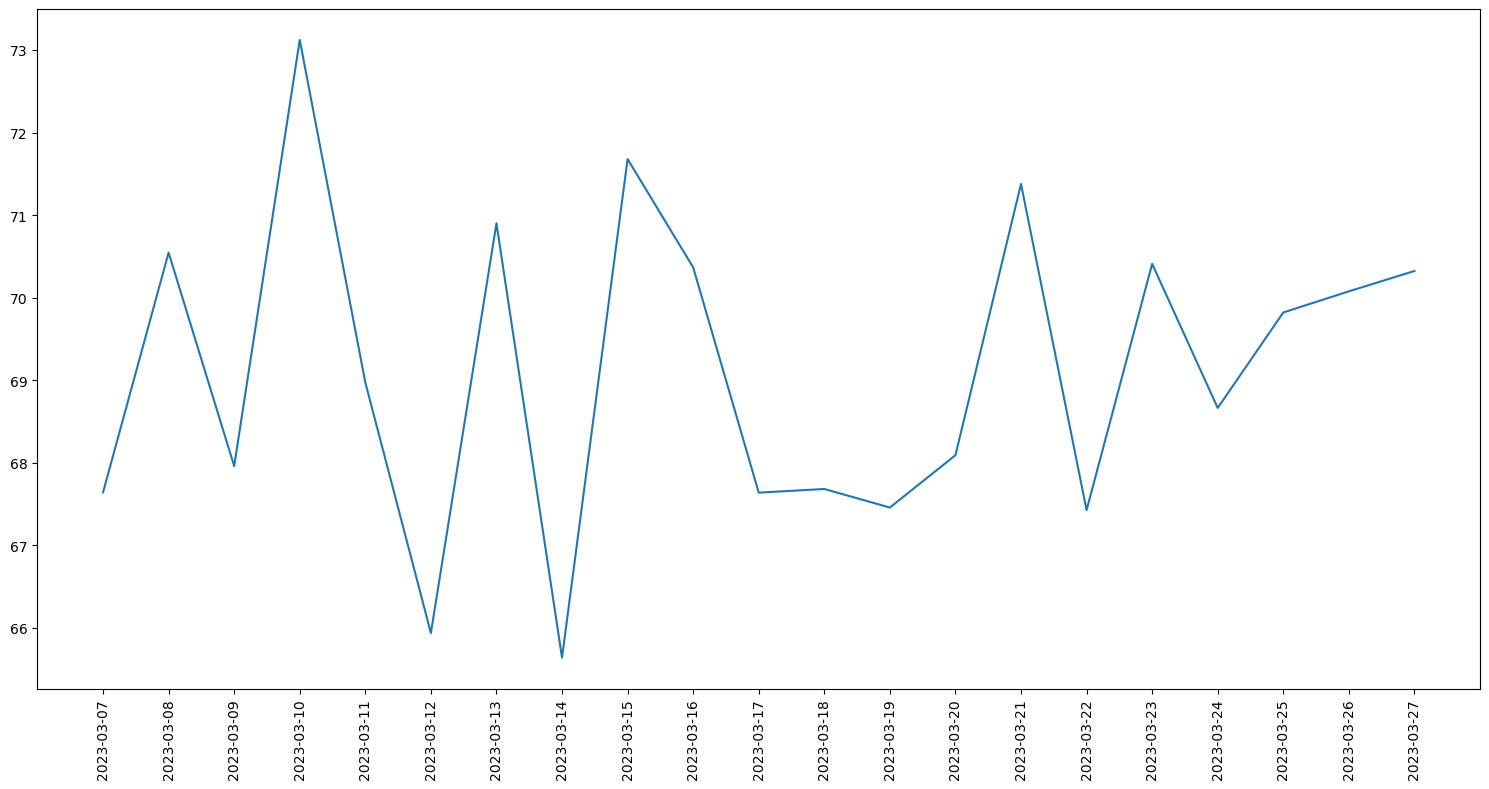

In [8]:
# overall

fig = plt.figure(figsize=(15, 8))
performance_df_grouped = performance_df.groupby([performance_df['Date'].dt.date])['Accuracy'].mean().reset_index()
performance_df_grouped['Date'] = pd.to_datetime(performance_df_grouped['Date'])
plt.plot(performance_df_grouped['Date'], performance_df_grouped['Accuracy'])
plt.xticks(performance_df_grouped['Date'], rotation=90)
fig.tight_layout()


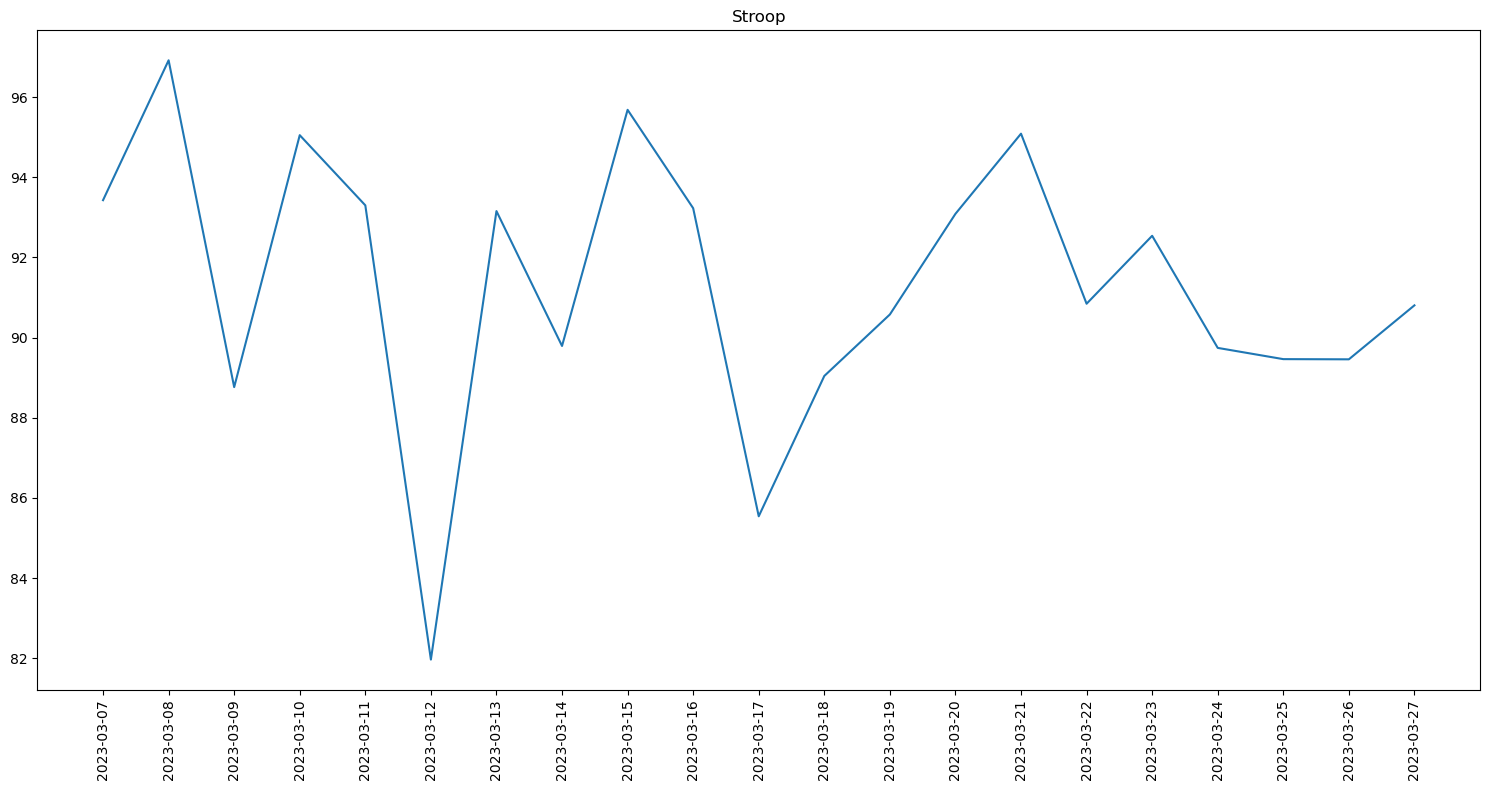

In [14]:
# stroop

fig = plt.figure(figsize=(15, 8))
stroop_acc_df_grouped = stroop_acc_df.groupby([stroop_acc_df['Date'].dt.date])['Accuracy'].mean().reset_index()
stroop_acc_df_grouped['Date'] = pd.to_datetime(stroop_acc_df_grouped['Date'])
plt.plot(stroop_acc_df_grouped['Date'], stroop_acc_df_grouped['Accuracy'])
plt.xticks(stroop_acc_df_grouped['Date'], rotation=90)
plt.title("Stroop")
fig.tight_layout()

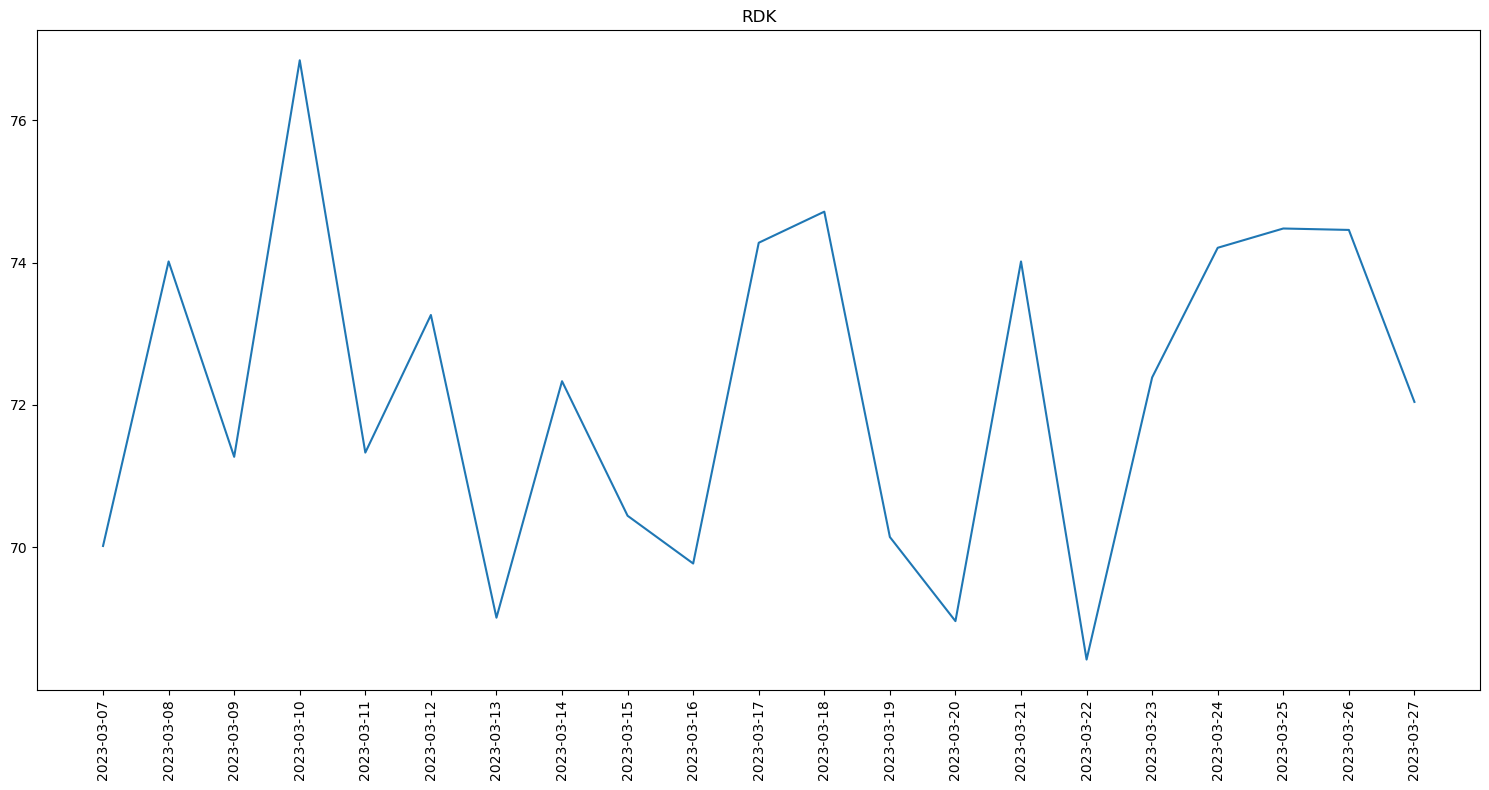

In [15]:
# rdk

fig = plt.figure(figsize=(15, 8))
rdk_acc_df_grouped = rdk_acc_df.groupby([rdk_acc_df['Date'].dt.date])['Accuracy'].mean().reset_index()
rdk_acc_df_grouped['Date'] = pd.to_datetime(rdk_acc_df_grouped['Date'])
plt.plot(rdk_acc_df_grouped['Date'], rdk_acc_df_grouped['Accuracy'])
plt.xticks(rdk_acc_df_grouped['Date'], rotation=90)
plt.title("RDK")
fig.tight_layout()

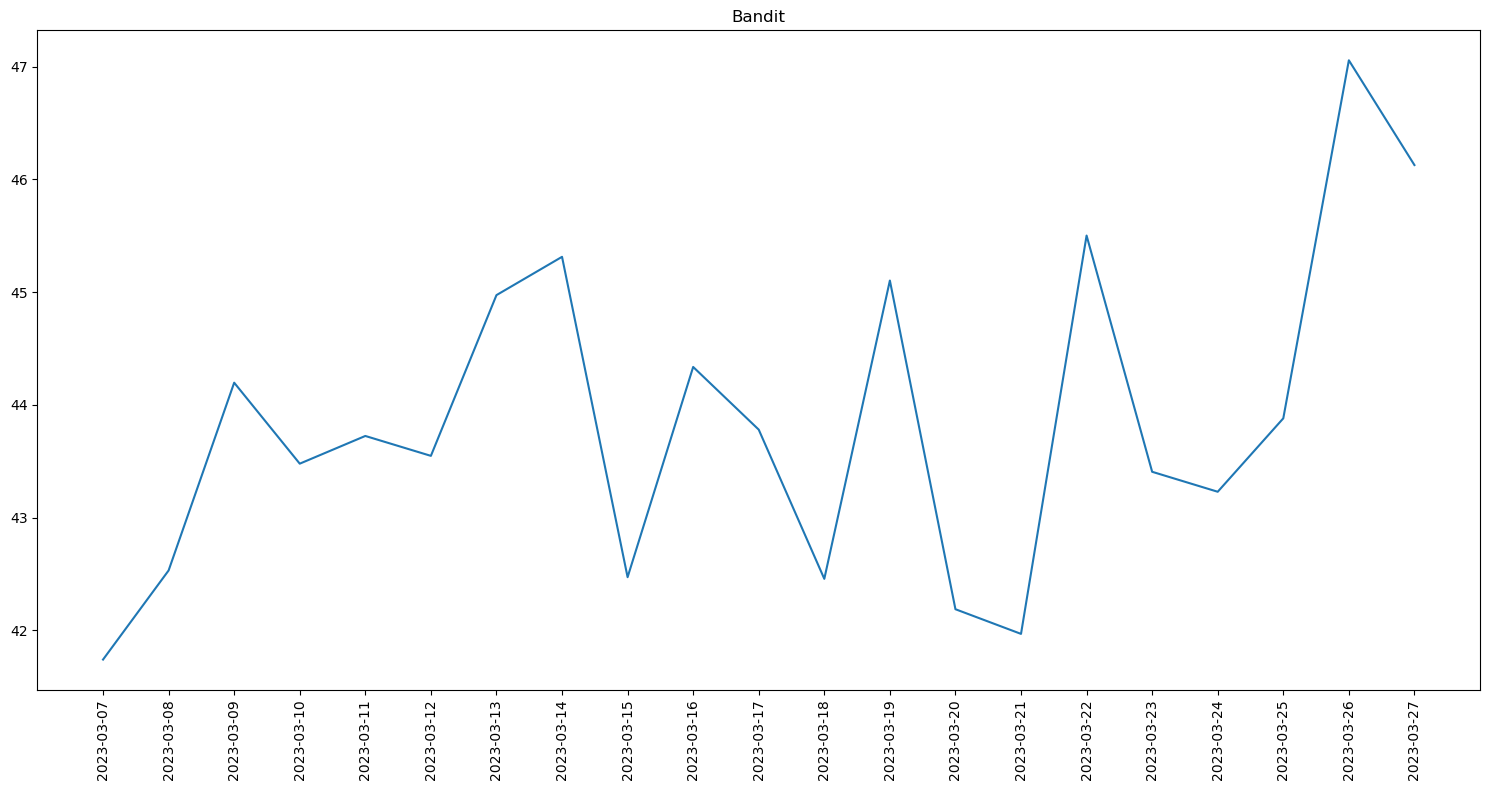

In [16]:
# bandit

fig = plt.figure(figsize=(15, 8))
bandit_acc_df_grouped = bandit_acc_df.groupby([bandit_acc_df['Date'].dt.date])['Accuracy'].mean().reset_index()
bandit_acc_df_grouped['Date'] = pd.to_datetime(bandit_acc_df_grouped['Date'])
plt.plot(bandit_acc_df_grouped['Date'], bandit_acc_df_grouped['Accuracy'])
plt.xticks(bandit_acc_df_grouped['Date'], rotation=90)
plt.title("Bandit")
fig.tight_layout()

### Days of the week (Monday = 0 ... Sunday = 6)

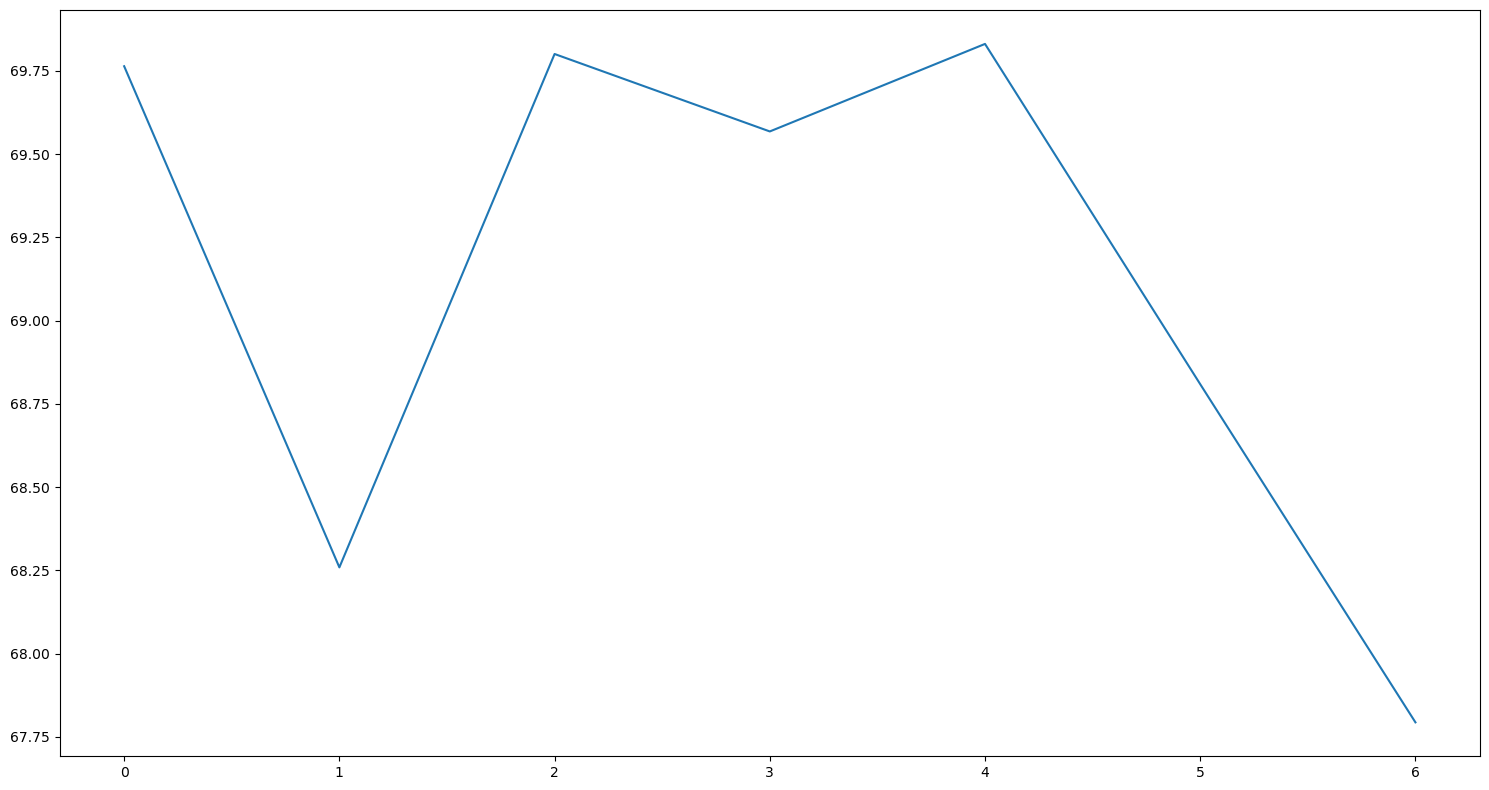

In [9]:
fig = plt.figure(figsize=(15, 8))

performance_df['Day'] = performance_df['Date'].dt.dayofweek
performance_df_grouped = performance_df.groupby([performance_df['Day']])['Accuracy'].mean().reset_index()
plt.plot(performance_df_grouped['Day'], performance_df_grouped['Accuracy'])
plt.xticks(performance_df_grouped['Day'])
fig.tight_layout()

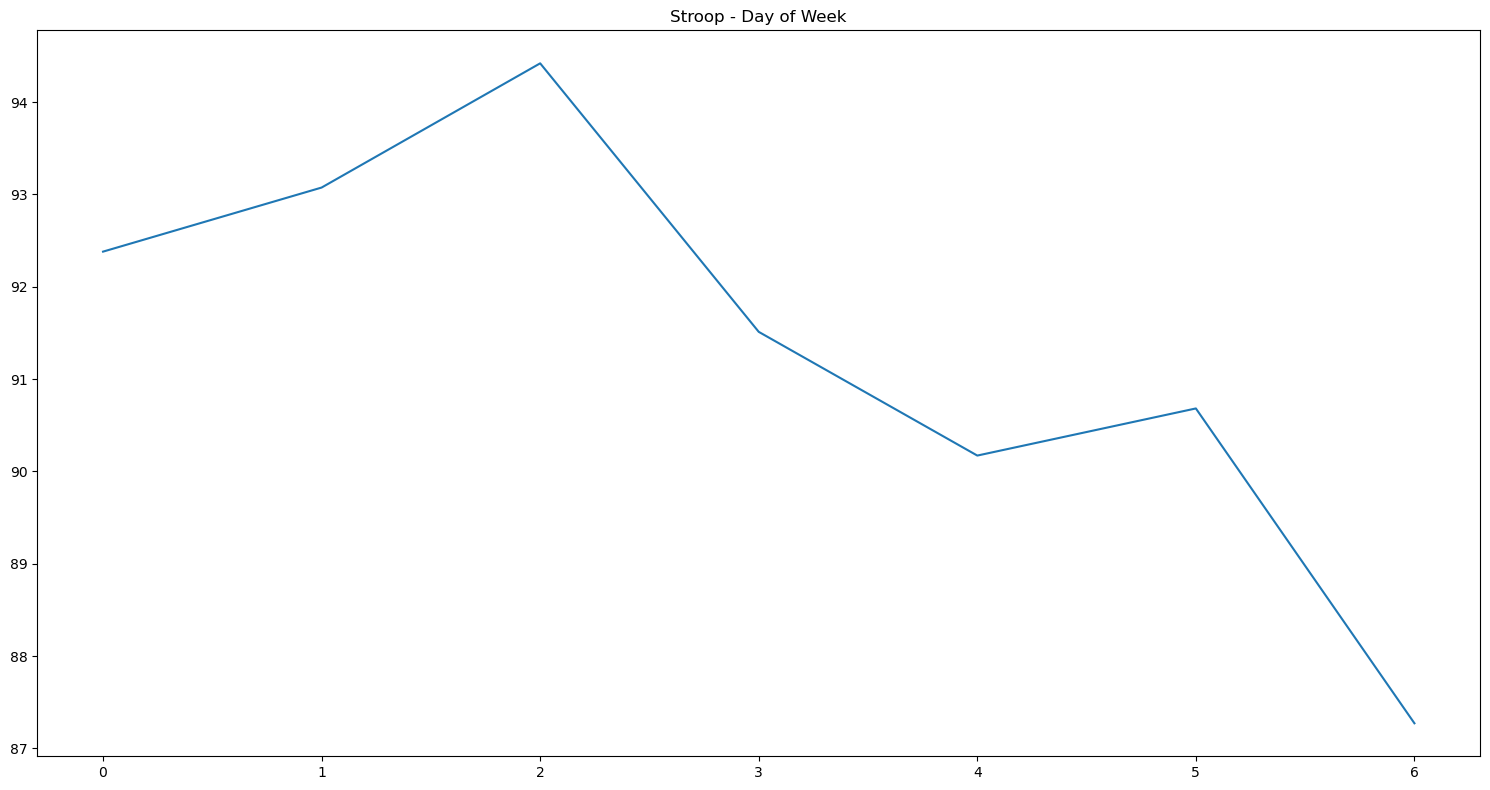

In [24]:
fig = plt.figure(figsize=(15, 8))

stroop_acc_df['Day'] = stroop_acc_df['Date'].dt.dayofweek
stroop_acc_df_grouped = stroop_acc_df.groupby([stroop_acc_df['Day']])['Accuracy'].mean().reset_index()
plt.plot(stroop_acc_df_grouped['Day'], stroop_acc_df_grouped['Accuracy'])
plt.xticks(stroop_acc_df_grouped['Day'])
plt.title("Stroop - Day of Week (Accuracy)")
fig.tight_layout()

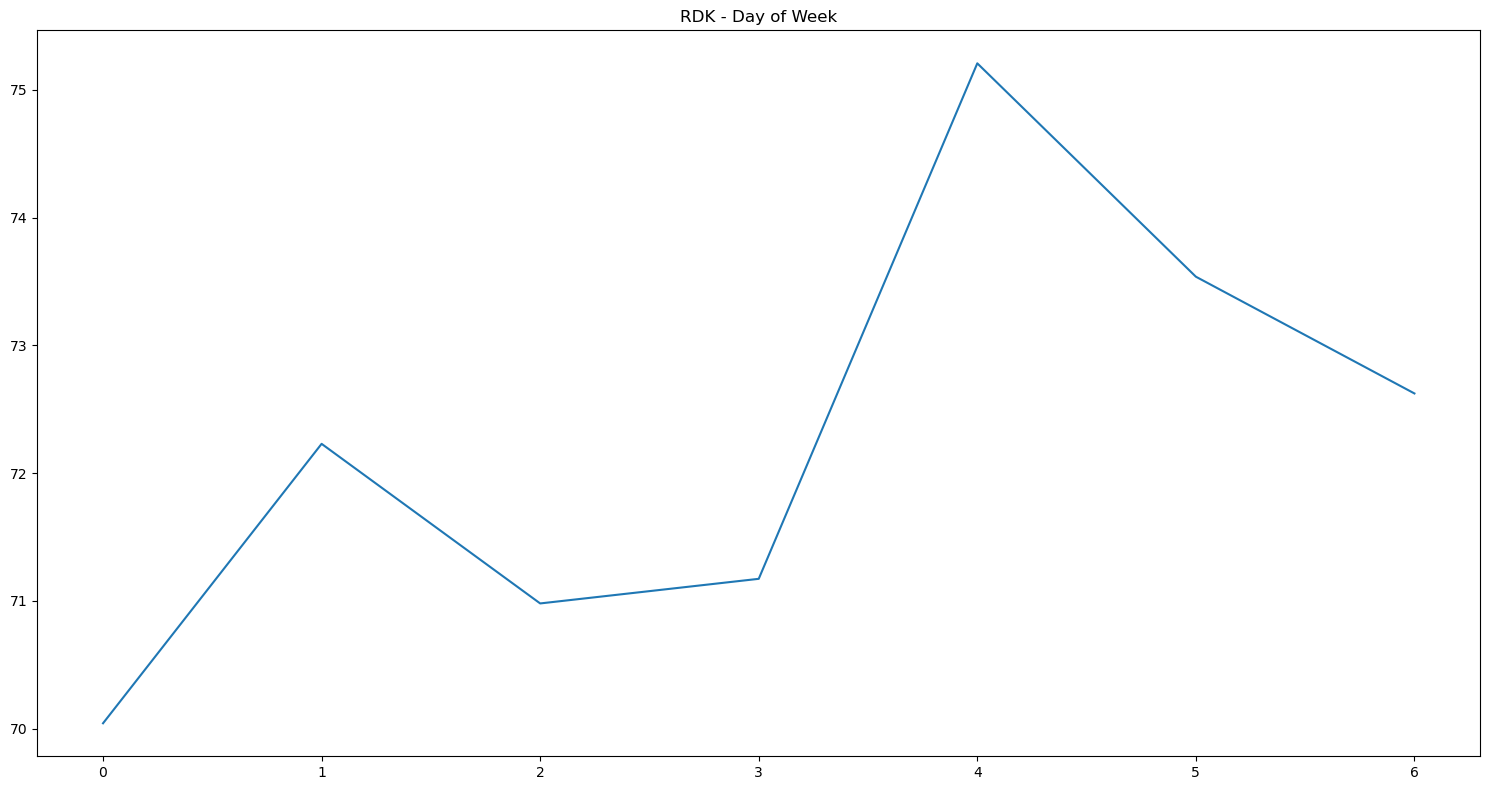

In [23]:
fig = plt.figure(figsize=(15, 8))

rdk_acc_df['Day'] = rdk_acc_df['Date'].dt.dayofweek
rdk_acc_df_grouped = rdk_acc_df.groupby([rdk_acc_df['Day']])['Accuracy'].mean().reset_index()
plt.plot(rdk_acc_df_grouped['Day'], rdk_acc_df_grouped['Accuracy'])
plt.xticks(rdk_acc_df_grouped['Day'])
plt.title("RDK - Day of Week (Accuracy)")
fig.tight_layout()

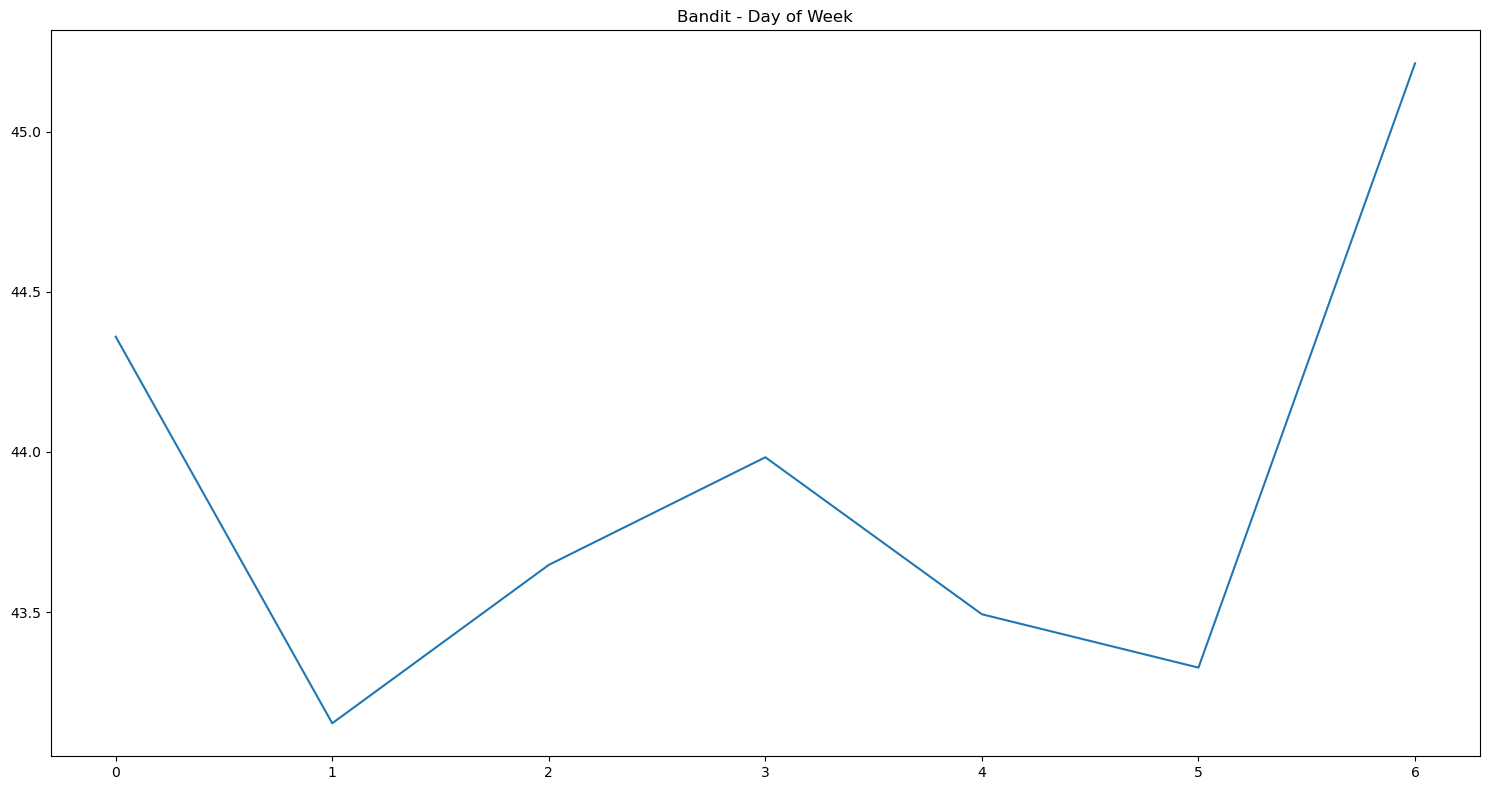

In [26]:
fig = plt.figure(figsize=(15, 8))

bandit_acc_df['Day'] = bandit_acc_df['Date'].dt.dayofweek
bandit_acc_df_grouped = bandit_acc_df.groupby([bandit_acc_df['Day']])['Accuracy'].mean().reset_index()
plt.plot(bandit_acc_df_grouped['Day'], bandit_acc_df_grouped['Accuracy'])
plt.xticks(bandit_acc_df_grouped['Day'])
plt.title("Bandit - Day of Week (Accuracy)")
fig.tight_layout()

In [12]:
performance_df["Day"].value_counts()

3    240
0    235
1    234
4    234
5    233
6    233
2    231
Name: Day, dtype: int64

In [10]:
# recreating manip datasets

manip_1 = performance_df[performance_df["Manipulation"].str.contains("vanilla")][["Accuracy", "Date"]]
manip_2 = performance_df[performance_df["Manipulation"].str.contains("progress")][["Accuracy", "Date"]]
manip_3 = performance_df[performance_df["Manipulation"].str.contains("eyes")][["Accuracy", "Date"]]
manip_4 = performance_df[performance_df["Manipulation"].str.contains("posneg")][["Accuracy", "Date"]]
manip_5 = performance_df[performance_df["Manipulation"].str.contains("final")][["Accuracy", "Date"]]
manip_6 = performance_df[performance_df["Manipulation"].str.contains("bonus")][["Accuracy", "Date"]]
manip_7 = performance_df[performance_df["Manipulation"].str.contains("video")][["Accuracy", "Date"]]

print(manip_3.head())

      Accuracy                Date
157  98.437500 2023-03-07 10:23:50
158  99.479167 2023-03-08 10:02:57
159  91.145833 2023-03-07 10:21:55
160  89.062500 2023-03-07 10:20:07
161  91.666667 2023-03-07 10:15:31


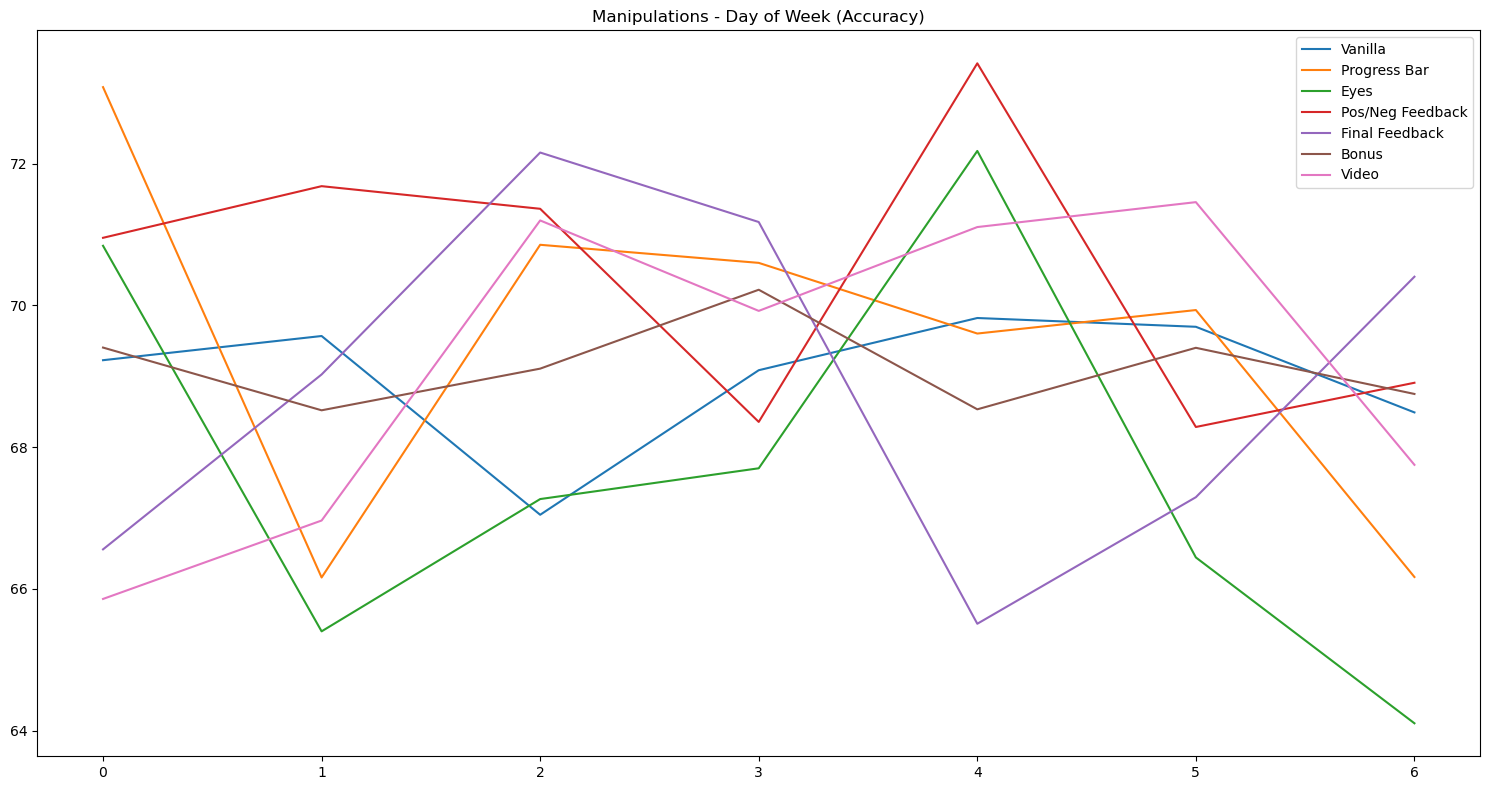

In [13]:
fig = plt.figure(figsize=(15, 8))

manip_1['Day'] = manip_1['Date'].dt.dayofweek
manip_1_grouped = manip_1.groupby([manip_1['Day']])['Accuracy'].mean().reset_index()
plt.plot(manip_1_grouped['Day'], manip_1_grouped['Accuracy'], label='Vanilla')
plt.xticks(manip_1_grouped['Day'])

manip_2['Day'] = manip_2['Date'].dt.dayofweek
manip_2_grouped = manip_2.groupby([manip_2['Day']])['Accuracy'].mean().reset_index()
plt.plot(manip_2_grouped['Day'], manip_2_grouped['Accuracy'], label='Progress Bar')
plt.xticks(manip_2_grouped['Day'])

manip_3['Day'] = manip_3['Date'].dt.dayofweek
manip_3_grouped = manip_3.groupby([manip_3['Day']])['Accuracy'].mean().reset_index()
plt.plot(manip_3_grouped['Day'], manip_3_grouped['Accuracy'], label='Eyes')
plt.xticks(manip_3_grouped['Day'])

manip_4['Day'] = manip_4['Date'].dt.dayofweek
manip_4_grouped = manip_4.groupby([manip_4['Day']])['Accuracy'].mean().reset_index()
plt.plot(manip_4_grouped['Day'], manip_4_grouped['Accuracy'], label='Pos/Neg Feedback')
plt.xticks(manip_4_grouped['Day'])

manip_5['Day'] = manip_5['Date'].dt.dayofweek
manip_5_grouped = manip_5.groupby([manip_5['Day']])['Accuracy'].mean().reset_index()
plt.plot(manip_5_grouped['Day'], manip_5_grouped['Accuracy'], label='Final Feedback')
plt.xticks(manip_5_grouped['Day'])

manip_6['Day'] = manip_6['Date'].dt.dayofweek
manip_6_grouped = manip_6.groupby([manip_6['Day']])['Accuracy'].mean().reset_index()
plt.plot(manip_6_grouped['Day'], manip_6_grouped['Accuracy'], label='Bonus')
plt.xticks(manip_6_grouped['Day'])

manip_7['Day'] = manip_7['Date'].dt.dayofweek
manip_7_grouped = manip_7.groupby([manip_7['Day']])['Accuracy'].mean().reset_index()
plt.plot(manip_7_grouped['Day'], manip_7_grouped['Accuracy'], label='Video')
plt.xticks(manip_7_grouped['Day'])

plt.title("Manipulations - Day of Week (Accuracy)")
plt.legend()
fig.tight_layout()